In [ ]:
import torch
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

torch.set_num_threads(12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5,), (0.5,)), # 归一化
                             ])

train_dataset = torchvision.datasets.MNIST(root='./mnist', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)

batch_size = 4
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=12)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=12)


import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1)   #展开成一维的
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

net = Net()
net.to(device)
print(net)

from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 优化器

import time

start_time = time.time()

for epoch in range(100):
    running_loss = 0.0 #初始化loss
    for i, (inputs, labels) in enumerate(trainloader, 0):

        # 输入数据

        inputs =  inputs.to(device)
        labels =  labels.to(device)

        # 梯度清零
        optimizer.zero_grad()

        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   

        # 更新参数 
        optimizer.step()

        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0

stop_time = time.time()

print('Finished Training 耗时： ', (stop_time - start_time), '秒')

PATH = './mnist_net_XXX.pth'
torch.save(net.state_dict(), PATH)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,  2000] loss: 1.187
[1,  4000] loss: 0.226
[1,  6000] loss: 0.135
[1,  8000] loss: 0.117
[1, 10000] loss: 0.095
[1, 12000] loss: 0.099
[1, 14000] loss: 0.082
[2,  2000] loss: 0.073
[2,  4000] loss: 0.061
[2,  6000] loss: 0.056
[2,  8000] loss: 0.059
[2, 10000] loss: 0.056
[2, 12000] loss: 0.059


实际的label:         7        2        1        0
(28, 112, 3)
3136
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


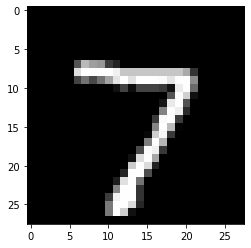

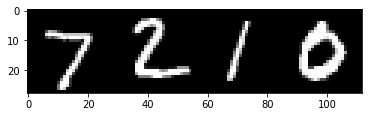

In [22]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

#**测试图像的实际labels**
dataiter = iter(testloader) #把测试数据放在迭代器iter
images, labels = dataiter.next() # 一个batch返回4张图片，依次获取下一个数据

print('实际的label: ', ' '.join( '%08s'%classes[labels[j]] for j in range(4)))

img = images[0] / 2 + 0.5     # 把数据退回(0,1)区间
npimg = img.numpy()
npimg = np.transpose(npimg, (1, 2, 0))
npimg = cv2.cvtColor(npimg, cv2.COLOR_GRAY2RGB)
plt.imshow(npimg)
plt.show()

images = images/2+0.5
img = np.empty((28,28*4), dtype=np.float32)
img[:,0:28] = images[0].numpy()
img[:,28:56] = images[1].numpy()
img[:,56:84] = images[2].numpy()
img[:,84:112] = images[3].numpy()

# cv2.imshow('img', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

img2 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
print(img2.shape)
plt.imshow(img2)
plt.show()
print(np.sum(img2[:,:,0] == img))
print(img2[:,:,0] == img)


In [23]:
images = images.to(device)

outputs = net(images)

_, predicted = torch.max(outputs.data,1)

print('预测结果：', ' '.join('%5s'%classes[predicted[j]] for j in range(4)))

预测结果：     7     2     1     0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
68
10000张测试集合中的准确率为： 99.32
tensor(9932, device='cuda:0')


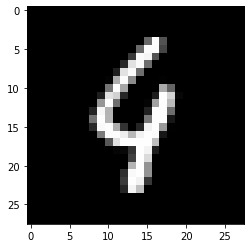

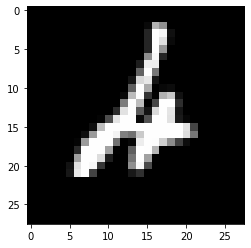

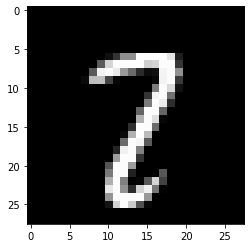

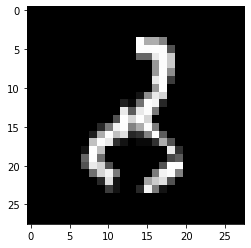

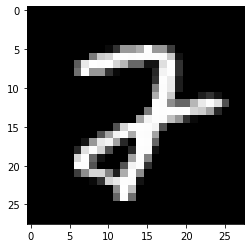

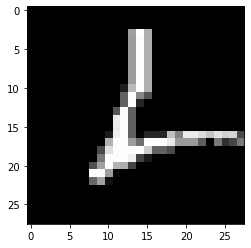

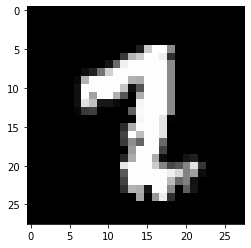

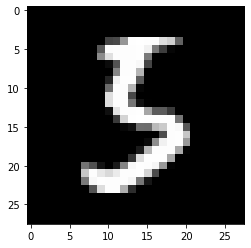

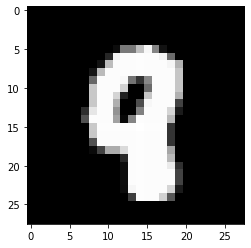

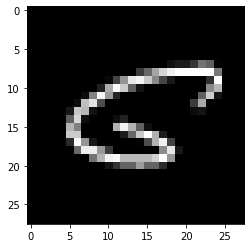

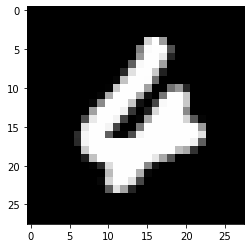

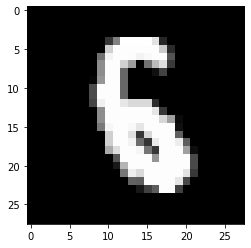

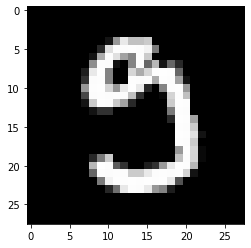

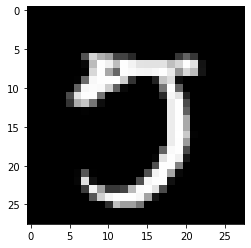

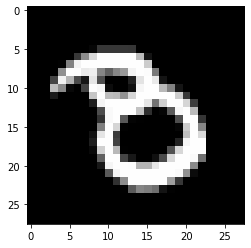

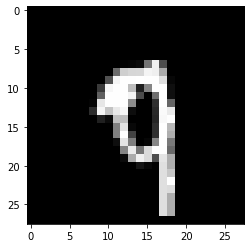

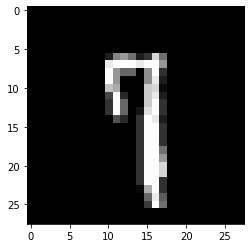

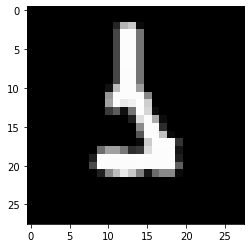

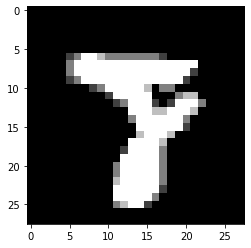

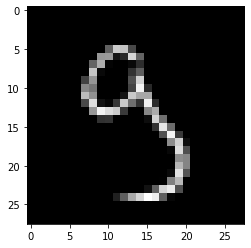

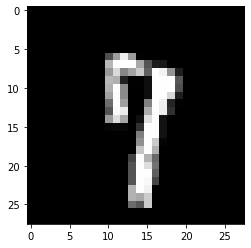

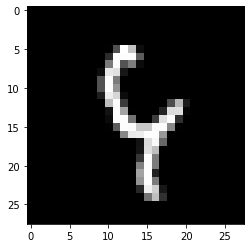

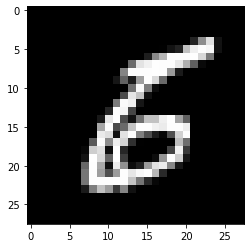

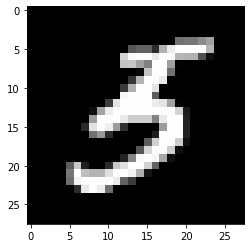

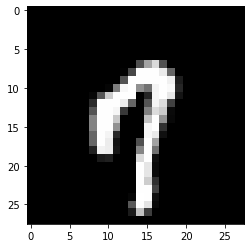

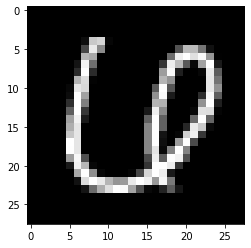

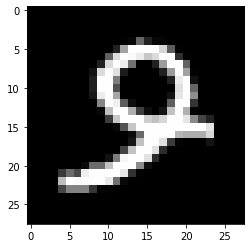

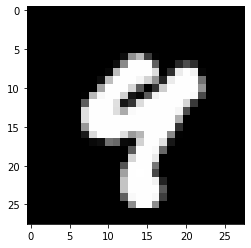

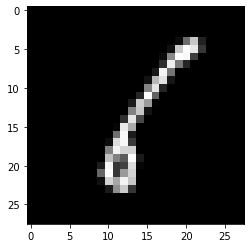

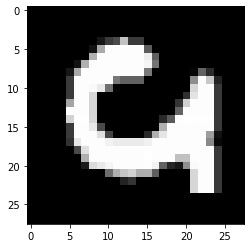

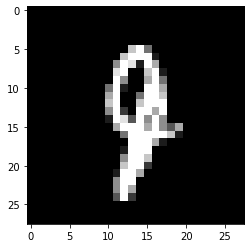

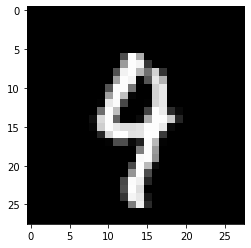

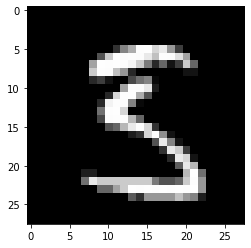

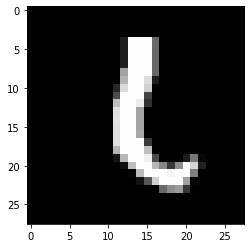

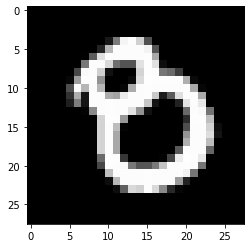

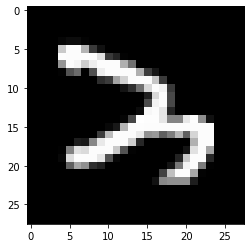

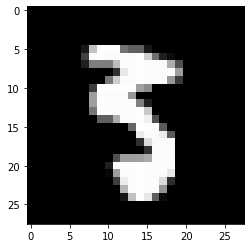

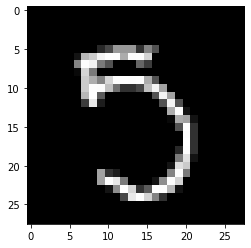

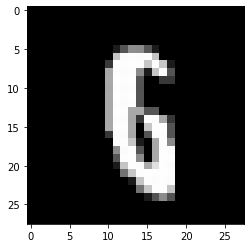

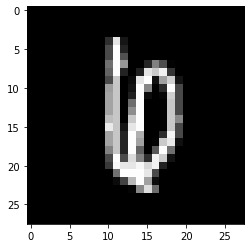

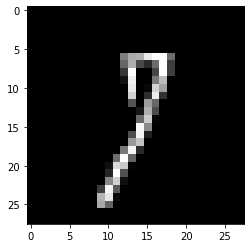

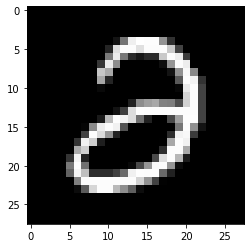

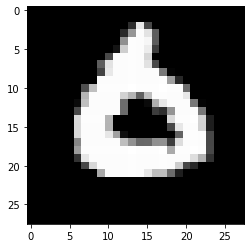

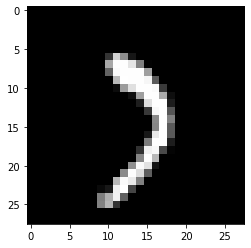

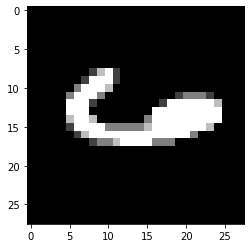

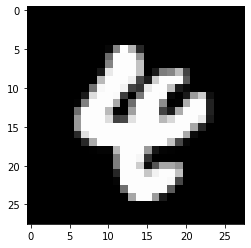

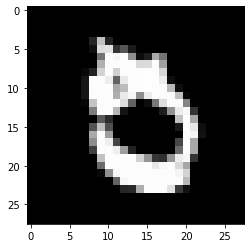

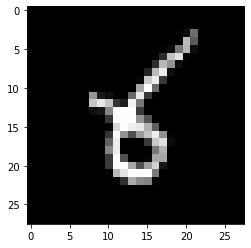

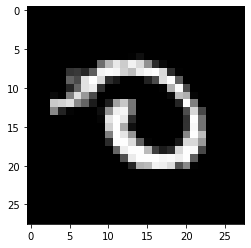

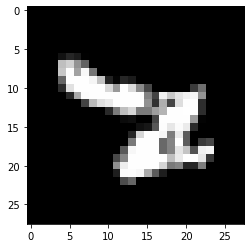

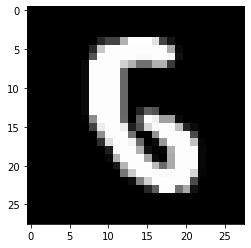

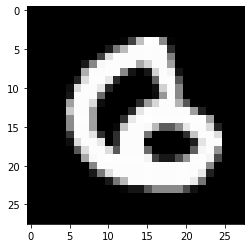

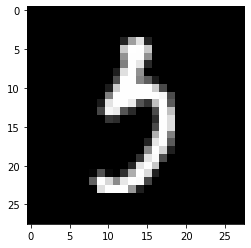

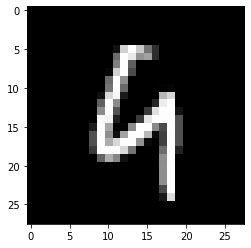

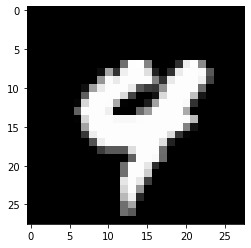

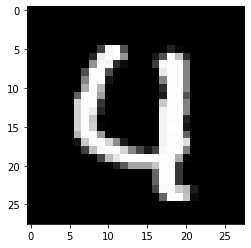

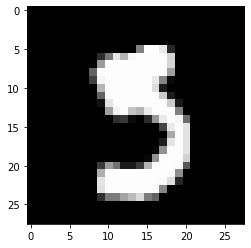

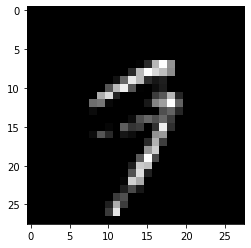

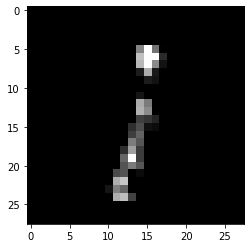

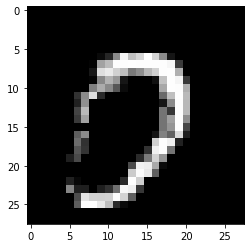

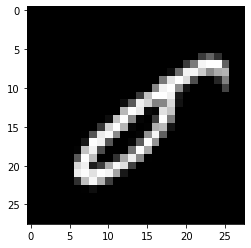

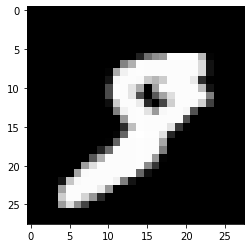

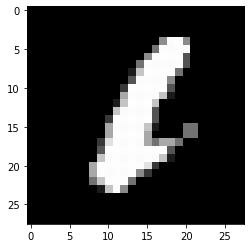

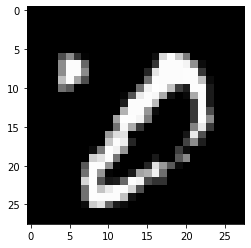

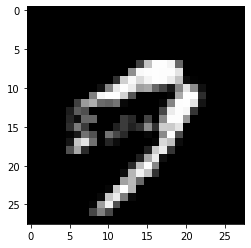

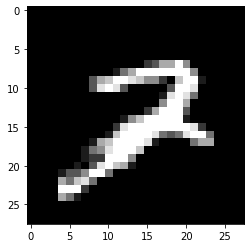

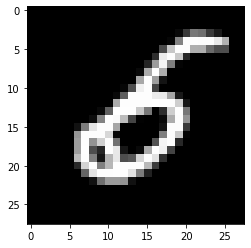

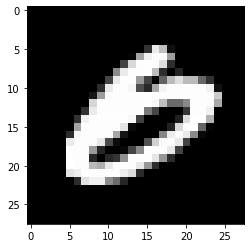

In [17]:
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), # 转为Tensor
        torchvision.transforms.Normalize((0.5,), (0.5,)), # 归一化
                             ])

batch_size = 4
test_dataset = torchvision.datasets.MNIST(root='./mnist', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1)   #展开成一维的
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

net = Net()
net.to(device)
print(net)

PATH = './mnist_net_100.pth'
pretrained_net = torch.load(PATH)
net.load_state_dict(pretrained_net)

#整个测试集上预测
correct = 0
total = 0

err_sum = 0

with torch.no_grad():
    for (images,labels) in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
        
        for index in range(4):
            if predicted[index] != labels[index]:
                # print(index)
                err_sum = err_sum+1
                
                img = np.empty((28,28), dtype=np.float32)
                img[:,:] = images[index].cpu().numpy()/2+0.5
                img2 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)                
                plt.imshow(img2)
                plt.show()  
                
print(err_sum)
print('10000张测试集合中的准确率为：', (correct.cpu().numpy()/total * 100))
print(correct)

